In [19]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet, LassoCV, ElasticNetCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.neural_network import MLPRegressor
from utils.ml_utils import *

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import ParameterSampler
from tqdm import tqdm

from data_prep import load_features_data
from sklearn.feature_selection import RFECV, SelectFromModel
from sklearn.model_selection import TimeSeriesSplit

from sklearn.decomposition import PCA



**Load the features data, these are popular trend following features used in prior literature, this notebook assumes you have the pickle file residual_returns.pkl saved in the root directory, you can download this file from the OneDrive**

In [20]:
feats = load_features_data()
feats.tail()


ret      rVol    1d_ret   1wk_ret    1m_ret  \
date       cluster                                                      
2024-03-15 15        3.398228  0.010781 -0.018600 -0.010795 -0.003738   
           16        3.080426  0.010995 -0.020717 -0.020520 -0.008363   
           17        4.019482  0.011090 -0.018740 -0.010313  0.002589   
           18       10.257413  0.011017 -0.014164 -0.005898  0.047696   
           19        3.623791  0.010924  0.001962  0.001796  0.001793   

                      1Q_ret    6M_ret   12M_ret  feature_1d_ra  \
date       cluster                                                
2024-03-15 15      -0.010729  0.088150  0.044806      -1.725280   
           16       0.004148  0.084058 -0.022932      -1.884206   
           17      -0.059504 -0.079410 -0.113126      -1.689814   
           18       0.064581  0.131315  0.153882      -1.285637   
           19       0.111935  0.238240  0.080132       0.179593   

                    feature_1wk_ra  ...  lag5_feature_MACD_short  \
date       cluster                  ...                            
2024-03-15 15            -0.447788  ...                 0.138748   
           16            -0.834625  ...                 0.097605   
           17            -0.415871  ...                 0.101396   
           18            -0.239423  ...                 0.483758   
           19             0.073513  ...                 0.173823   

                    lag5_feature_MACD_medium  lag5_feature_MACD_long  \
date       cluster                                                     
2024-03-15 15                       0.259889                0.574767   
           16                       0.322557                0.642906   
           17                       0.006033               -0.415118   
           18                       0.557877                0.717302   
           19                       0.503369                0.849991   

                    lag5_feature_skew6m  lag5_feature_skew12m  \
date       cluster                                              
2024-03-15 15                 -0.202834             -0.023611   
           16                 -0.195628             -0.024484   
           17                 -0.213701             -0.034735   
           18                 -0.229808             -0.042143   
           19                 -0.236460             -0.033288   

                    lag5_feature_kurt6m  lag5_feature_kurt12m  fwd_ret1d  \
date       cluster                                                         
2024-03-15 15                  0.229975              0.324046        NaN   
           16                  0.209541              0.330980        NaN   
           17                  0.168224              0.327998        NaN   
           18                  0.153079              0.316662        NaN   
           19                  0.163940              0.359519        NaN   

                    target  targetBin  
date       cluster                     
2024-03-15 15          NaN        NaN  
           16          NaN        NaN  
           17          NaN        NaN  
           18          NaN        NaN  
           19          NaN        NaN  

[5 rows x 89 columns]

count    125019.000000
mean          0.029297
std           1.228097
min         -18.536928
25%          -0.597784
50%           0.062029
75%           0.686203
max          70.166324
Name: target, dtype: float64
count    125019.000000
mean          0.028428
std           1.201198
min         -10.000000
25%          -0.597784
50%           0.062029
75%           0.686203
max          10.000000
Name: target, dtype: float64


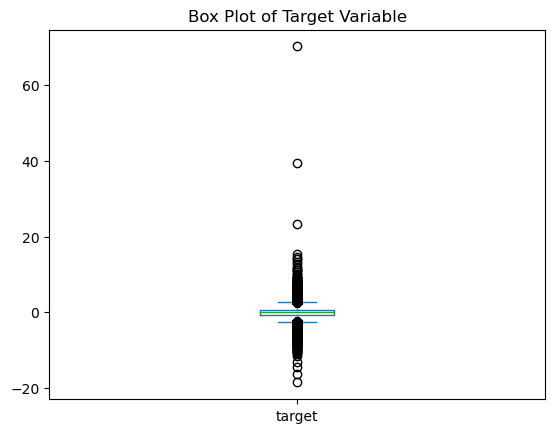

In [21]:
# distribution of tragets
feats['target'].plot(kind='box', title="Box Plot of Target Variable")
print(feats['target'].describe())

# clip the three large outliers
feats['target'] = feats['target'].clip(-10., 10.)
print(feats['target'].describe())

<Axes: >

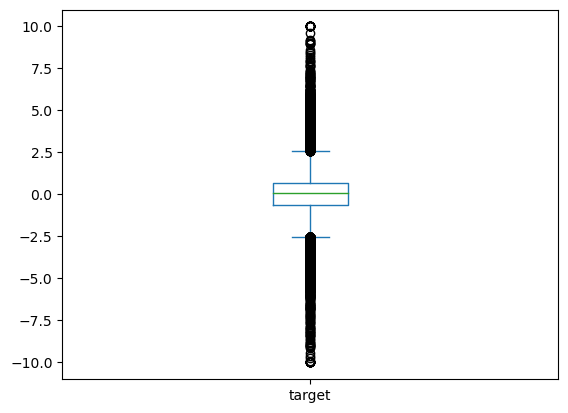

In [22]:
feats['target'].plot(kind='box')

**Extract the predictive features and target, which is one day forward risk adjusted return - drop na on this subset**

In [23]:
features = [f for f in feats.columns if f.startswith("feature")]
target = ["target"]
lag_feats = [f for f in feats.columns if f.startswith('lag')]

# make a new feature vector for features + lags

all_feats = features + lag_feats + target
feats.dropna(subset=all_feats, inplace=True)
feats = feats[all_feats]

print("Shape of features", feats.shape)



Shape of features (119900, 79)


**Break out X and y and set up cross-validation, define models**

In [24]:
X = feats[all_feats].copy()

# set some configs
N_ITER=50

# Random Forest Regressor
baseRF = RandomForestRegressor(max_depth=5, 
                               n_estimators=1000,
                               max_features=int(1),
                               random_state=49, 
                               n_jobs=-1)

# simple-grid
grid = {'rf__n_estimators': np.arange(100, 2000, 100),
        'rf__max_depth': [3, 6, 9, 12],
        'rf__max_features': [int(1), 'sqrt'],
        'rf__min_weight_fraction_leaf': np.arange(0.0, 0.05, 0.005)}
paramsRF = ParameterSampler(n_iter=N_ITER, param_distributions=grid)

rfPipe = Pipeline(steps=[('scaler', RobustScaler()), ('rf',baseRF)])
rfPipeFS = Pipeline(steps=[('scaler', RobustScaler()),
                           ('selector', SelectFromModel(baseRF, threshold='mean')),
                           ('rf',baseRF)])

# Elastic Net Regressor
net = ElasticNet(max_iter=1000)
eNetPipe = Pipeline(steps=[('scaler', RobustScaler()), ('net', net)])
eNetPipePCA = Pipeline(steps=[('scaler', RobustScaler()),
                              ('pca', PCA(n_components=.95)),
                              ('net', net)])

eNet_grid = {'net__alpha': [1e-5, 1e-4, 1e-3, 1e-2],
             'net__l1_ratio': np.arange(0.10, .90, 0.01)}

paramsNet = ParameterSampler(n_iter=N_ITER, param_distributions=eNet_grid)

# MLP Regressor
mlp = MLPRegressor(hidden_layer_sizes=(16, 8),
                   random_state=49,
                   shuffle=False,
                   max_iter=500,
                   early_stopping=True,
                   learning_rate='constant')

mlp_pipe = Pipeline(steps=[('scaler', RobustScaler()), ('mlp', mlp)])
mlp_pipeFS = Pipeline(steps=[('scaler', RobustScaler()),
                             ('selector', SelectFromModel(baseRF, threshold='mean')),
                             ('mlp', mlp)])
mlp_grid = {'mlp__learning_rate_init': [.000001, .00001, .0001, .001],
            'mlp__batch_size': [32, 64, 128, 256],
            'mlp__hidden_layer_sizes': [(12, 6), (16, 8), (6, 3)],
            'mlp__alpha': [.000001, .00001, .0001, .001, .01]}
mlp_sampler = ParameterSampler(n_iter=N_ITER, param_distributions=mlp_grid)

# append the models
models = [(mlp_pipe, mlp_sampler, 'preds_MLP'),
          (mlp_pipeFS, mlp_sampler, 'preds_MLP_FS'),
          (eNetPipe, paramsNet, 'preds_eNet'),
          (eNetPipePCA, paramsNet, 'preds_eNetPCA'),
          (rfPipe, paramsRF, 'preds_RF'),
          (rfPipeFS, paramsRF, 'preds_RF_FS')]


**Form the training loop, here we train on 3 year expanding windows, using 90% of each split for training and 10% for tuning hyper-parameters, we then use the same model to forecast forward 3-years before re-training again.**

In [25]:
def train_single_model(model, sampler, model_name):
    predictions = []
    scores = []
    for train, test in tqdm(get_cv_splits(X, split_length=252*5)):
        # break out X and y train, test
        X_train, y_train = train[features], train[target] 
        X_test, y_test = test[features], test[target]

        # hyper-param loop
        X_train2, X_val, y_train2, y_val = train_val_split(X_train, y_train)
        print(X_train2.shape, X_val.shape)

        # inner loop for parameter tuning
        gscv_scores = {'scores': [], 'grid':[]}
        for k, p in enumerate(sampler):
            model.set_params(**p)
            try:
                model.n_jobs=-1
            except Exception as e:
                pass
            model.fit(X_train2, y_train2.values.reshape(y_train2.shape[0], ))
            _pred = model.predict(X_val)
            _score = mean_squared_error(y_val, _pred)
            gscv_scores['scores'].append(_score)
            gscv_scores['grid'].append(p)
            print(f'Iter: {k}: Score: {_score}')

        # now fit the best model
        best_model = pd.DataFrame(gscv_scores).sort_values(by='scores').head(1)['grid'].values[0]
        print(pd.DataFrame(gscv_scores).sort_values(by='scores').head(1))
        print(f'Best Model: {best_model}')
        best_model = model.set_params(**best_model)
        best_model.n_jobs=-1
        best_model.fit(X_train, y_train.values.reshape(y_train.shape[0], ))
        preds = best_model.predict(X_test)

        # append the predictions
        predictions.append(pd.Series(index=y_test.index, data=preds))
       
        # score
        scores.append(mean_squared_error(y_test, preds))

    # predictions
    predictions = pd.concat(predictions).to_frame(model_name)
    return predictions

# train all models selected
predictions = []
for model in models:
    out = train_single_model(model[0], model[1], model[2])
    predictions.append(out)

# concat the predictions by columns
predictions = pd.concat(predictions, axis=1)

0it [00:00, ?it/s]

4
(22698, 13) (2520, 13)
Iter: 0: Score: 1.5695559441186155
Iter: 1: Score: 1.5538991512473073
Iter: 2: Score: 1.511695616963648
Iter: 3: Score: 1.5714383746769396
Iter: 4: Score: 1.5610912213320103
Iter: 5: Score: 1.5714922585098985
Iter: 6: Score: 1.585930052219177
Iter: 7: Score: 1.5806578881545965
Iter: 8: Score: 1.5840456658848232
Iter: 9: Score: 1.5158070840786995


c:\Users\jaman\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Iter: 10: Score: 1.778308727766601
Iter: 11: Score: 1.526327582432145
Iter: 12: Score: 1.5540315299672618
Iter: 13: Score: 1.5141805370656394
Iter: 14: Score: 1.569658946990948
Iter: 15: Score: 1.570819672843301
Iter: 16: Score: 1.5506347313885065
Iter: 17: Score: 1.520412822367633
Iter: 18: Score: 1.5257591532803847
Iter: 19: Score: 1.6176496555397364
Iter: 20: Score: 1.6276754739863972
Iter: 21: Score: 1.5829550920284765


c:\Users\jaman\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Iter: 22: Score: 1.778306695564358
Iter: 23: Score: 1.5363346208680706


c:\Users\jaman\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Iter: 24: Score: 1.5882240195171047
Iter: 25: Score: 1.584463489282359
Iter: 26: Score: 1.5607619301826239


c:\Users\jaman\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Iter: 27: Score: 1.996699522210766
Iter: 28: Score: 1.5410065412343568
Iter: 29: Score: 1.627713667953174
Iter: 30: Score: 1.5684957883300807
Iter: 31: Score: 1.5116955746657974
Iter: 32: Score: 1.52260700995021


c:\Users\jaman\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Iter: 33: Score: 1.778308623781538
Iter: 34: Score: 1.6094944705458651
Iter: 35: Score: 1.5185480181293116


c:\Users\jaman\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Iter: 36: Score: 1.9967005776039495
Iter: 37: Score: 1.5745358000315106
Iter: 38: Score: 1.581170295475424
Iter: 39: Score: 1.5430765685322982
Iter: 40: Score: 1.514123410907738
Iter: 41: Score: 1.5714915331342885
Iter: 42: Score: 1.507608529838816
Iter: 43: Score: 1.5144109172547615
Iter: 44: Score: 1.5343369275448737
Iter: 45: Score: 1.5949299893748823
Iter: 46: Score: 1.5293589934834684
Iter: 47: Score: 1.5916319657024738
Iter: 48: Score: 1.6176393448718585


c:\Users\jaman\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Iter: 49: Score: 1.5384330609974848
      scores                                               grid
42  1.507609  {'mlp__learning_rate_init': 1e-05, 'mlp__hidde...
Best Model: {'mlp__learning_rate_init': 1e-05, 'mlp__hidden_layer_sizes': (6, 3), 'mlp__batch_size': 32, 'mlp__alpha': 0.01}


1it [05:39, 339.92s/it]

(45396, 13) (5040, 13)
Iter: 0: Score: 1.510357970114223
Iter: 1: Score: 1.7884133663059203
Iter: 2: Score: 1.8105012903919853
Iter: 3: Score: 1.7733566461931545
Iter: 4: Score: 1.813450465492491
Iter: 5: Score: 1.490001837202538
Iter: 6: Score: 1.6672280607798693
Iter: 7: Score: 1.5248242863563313
Iter: 8: Score: 1.4568357049640912
Iter: 9: Score: 1.4849808603808152
Iter: 10: Score: 1.495292964438934


c:\Users\jaman\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Iter: 11: Score: 1.6733762317148628
Iter: 12: Score: 1.5114424674031004
Iter: 13: Score: 1.6927925111710058
Iter: 14: Score: 1.6421274685481555
Iter: 15: Score: 1.7772589403741121
Iter: 16: Score: 1.4809722061856507
Iter: 17: Score: 1.5132688312163445
Iter: 18: Score: 1.4726253834268075
Iter: 19: Score: 1.474423962277312
Iter: 20: Score: 1.4552569316630926
Iter: 21: Score: 1.4974448435521481


c:\Users\jaman\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Iter: 22: Score: 1.6733562920503569
Iter: 23: Score: 2.703748639794367
Iter: 24: Score: 1.689621293118061
Iter: 25: Score: 1.8980260156971225
Iter: 26: Score: 1.4879273663197214
Iter: 27: Score: 1.76208276872405
Iter: 28: Score: 2.882419149870423


c:\Users\jaman\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Iter: 29: Score: 1.6733746081412586
Iter: 30: Score: 1.4672166996862521
Iter: 31: Score: 1.6957233132957414
Iter: 32: Score: 1.4677069387621058
Iter: 33: Score: 1.4942875589590445
Iter: 34: Score: 1.693418982349866
Iter: 35: Score: 1.4776846228920342
Iter: 36: Score: 1.485408754849916
Iter: 37: Score: 1.513138747073016
Iter: 38: Score: 1.4943906172713939
Iter: 39: Score: 1.472470764552852
Iter: 40: Score: 1.773020474018636
Iter: 41: Score: 1.4573336479972656


c:\Users\jaman\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Iter: 42: Score: 2.0738323643189585
Iter: 43: Score: 1.800442780337128
Iter: 44: Score: 1.510356396541489
Iter: 45: Score: 1.4675624659593085
Iter: 46: Score: 1.7298719631551476
Iter: 47: Score: 1.4580988766603769


c:\Users\jaman\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Iter: 48: Score: 2.152169788566098
Iter: 49: Score: 1.4613115329718196
      scores                                               grid
20  1.455257  {'mlp__learning_rate_init': 0.001, 'mlp__hidde...
Best Model: {'mlp__learning_rate_init': 0.001, 'mlp__hidden_layer_sizes': (6, 3), 'mlp__batch_size': 256, 'mlp__alpha': 1e-05}


2it [13:04, 401.61s/it]

(68076, 13) (7560, 13)
Iter: 0: Score: 1.3899506645001294
Iter: 1: Score: 1.4082853916390061
Iter: 2: Score: 1.3983778833803657
Iter: 3: Score: 1.446018472705023
Iter: 4: Score: 1.4025066237740234
Iter: 5: Score: 1.4033776147186627
Iter: 6: Score: 1.4199062008614873
Iter: 7: Score: 1.3881069086389803
Iter: 8: Score: 1.4083929761943152
Iter: 9: Score: 1.4043365080631025
Iter: 10: Score: 1.3873088680967045
Iter: 11: Score: 1.3844887114877618
Iter: 12: Score: 1.3965165078074466
Iter: 13: Score: 1.383342938749077
Iter: 14: Score: 1.3802220615025347
Iter: 15: Score: 1.3843863876536324
Iter: 16: Score: 1.4008695889078053
Iter: 17: Score: 1.3802963615691695
Iter: 18: Score: 1.411989155679296
Iter: 19: Score: 1.384916548295015
Iter: 20: Score: 1.39267270987991
Iter: 21: Score: 1.3970605048011868
Iter: 22: Score: 1.396496870430085
Iter: 23: Score: 1.4110602493446864
Iter: 24: Score: 1.3914313829301896
Iter: 25: Score: 1.3845635342208364
Iter: 26: Score: 1.4093910750821255
Iter: 27: Score: 1.403

c:\Users\jaman\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Iter: 48: Score: 1.596784760753772
Iter: 49: Score: 1.3846464607483926
      scores                                               grid
47  1.380144  {'mlp__learning_rate_init': 1e-05, 'mlp__hidde...
Best Model: {'mlp__learning_rate_init': 1e-05, 'mlp__hidden_layer_sizes': (12, 6), 'mlp__batch_size': 128, 'mlp__alpha': 0.01}


3it [22:58, 489.21s/it]

(90756, 13) (10080, 13)
Iter: 0: Score: 1.5070261880644134
Iter: 1: Score: 1.4837852278880261
Iter: 2: Score: 1.5162753381087737
Iter: 3: Score: 1.5100229929095665
Iter: 4: Score: 1.5182536132625737
Iter: 5: Score: 1.5099021659987015
Iter: 6: Score: 1.506701409136582
Iter: 7: Score: 1.531366047340112
Iter: 8: Score: 1.5063348888991293
Iter: 9: Score: 1.531402102293548


c:\Users\jaman\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Iter: 10: Score: 1.6109682005112682
Iter: 11: Score: 1.5074244595340982
Iter: 12: Score: 1.4922161413461728
Iter: 13: Score: 1.507901446905601
Iter: 14: Score: 1.5314058322789117
Iter: 15: Score: 1.4962471705792155
Iter: 16: Score: 1.4990791363482316
Iter: 17: Score: 1.4842439207974996
Iter: 18: Score: 1.5179675747736285
Iter: 19: Score: 1.503364473105036
Iter: 20: Score: 1.5209570243396526
Iter: 21: Score: 1.5226756191894133
Iter: 22: Score: 1.5135965584709214
Iter: 23: Score: 1.5005720273277654
Iter: 24: Score: 1.486273740376271
Iter: 25: Score: 1.5019155636309391
Iter: 26: Score: 1.4945696609398615
Iter: 27: Score: 1.492681784333824
Iter: 28: Score: 1.5067803794687917
Iter: 29: Score: 1.494807687460788
Iter: 30: Score: 1.4953553698533621
Iter: 31: Score: 1.498331044001922
Iter: 32: Score: 1.508827314266731
Iter: 33: Score: 1.503580840705988
Iter: 34: Score: 1.496238375711479
Iter: 35: Score: 1.489607077530534
Iter: 36: Score: 1.5018035937046545
Iter: 37: Score: 1.4960320502210254
It

4it [33:00, 495.03s/it]
0it [00:00, ?it/s]

4
(22698, 13) (2520, 13)
Iter: 0: Score: 1.5343369275448737
Iter: 1: Score: 1.5696580059218896
Iter: 2: Score: 1.516485672244892
Iter: 3: Score: 1.5346780112732306
Iter: 4: Score: 1.546691448945916
Iter: 5: Score: 1.5185480181293116
Iter: 6: Score: 1.578813678031043
Iter: 7: Score: 1.553195470388747
Iter: 8: Score: 1.5135437189863141
Iter: 9: Score: 1.6176393448718585


c:\Users\jaman\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Iter: 10: Score: 1.7783087476435455


c:\Users\jaman\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Iter: 11: Score: 1.9967005776039495
Iter: 12: Score: 1.5745358000315106
Iter: 13: Score: 1.514004838923503
Iter: 14: Score: 1.6405111689905332
Iter: 15: Score: 1.5140908562486355
Iter: 16: Score: 1.5185515920816934
Iter: 17: Score: 1.5079384971798615
Iter: 18: Score: 1.5293589934834684
Iter: 19: Score: 1.580653257637794
Iter: 20: Score: 1.5287417482522028
Iter: 21: Score: 1.524709420831576
Iter: 22: Score: 1.597271363502802
Iter: 23: Score: 1.5317123387123754
Iter: 24: Score: 1.585930052219177


c:\Users\jaman\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Iter: 25: Score: 1.5882186569320145
Iter: 26: Score: 1.5369124580687685


c:\Users\jaman\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Iter: 27: Score: 1.778308727766601
Iter: 28: Score: 1.5745497181452583
Iter: 29: Score: 1.553211411013444
Iter: 30: Score: 1.5144129568666578
Iter: 31: Score: 1.5788148917624185
Iter: 32: Score: 1.5141209142546526
Iter: 33: Score: 1.525961175387534
Iter: 34: Score: 1.5430765685322982
Iter: 35: Score: 1.6405112940508497


c:\Users\jaman\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Iter: 36: Score: 1.5882246378958116
Iter: 37: Score: 1.574557756525366
Iter: 38: Score: 1.528553942399463
Iter: 39: Score: 1.5425903285459235
Iter: 40: Score: 1.5840456658848232
Iter: 41: Score: 1.507608529838816
Iter: 42: Score: 1.5317328970320803


c:\Users\jaman\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Iter: 43: Score: 1.5882246199281023
Iter: 44: Score: 1.5760328000155073
Iter: 45: Score: 1.5346903660001314
Iter: 46: Score: 1.508011260393287
Iter: 47: Score: 1.5369760082925163
Iter: 48: Score: 1.578765212086901
Iter: 49: Score: 1.5806575080941432
      scores                                               grid
41  1.507609  {'mlp__learning_rate_init': 1e-05, 'mlp__hidde...
Best Model: {'mlp__learning_rate_init': 1e-05, 'mlp__hidden_layer_sizes': (6, 3), 'mlp__batch_size': 32, 'mlp__alpha': 0.01}


1it [06:23, 383.89s/it]

(45396, 13) (5040, 13)
Iter: 0: Score: 1.472956252521877


c:\Users\jaman\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Iter: 1: Score: 1.6733562920503569
Iter: 2: Score: 1.5350693295396507


c:\Users\jaman\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Iter: 3: Score: 2.073819755561519


c:\Users\jaman\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Iter: 4: Score: 2.0738323643189585
Iter: 5: Score: 1.4686150926545392
Iter: 6: Score: 1.5103516036070639
Iter: 7: Score: 1.7730543404694077
Iter: 8: Score: 2.504101553092651
Iter: 9: Score: 1.4943907337873767
Iter: 10: Score: 2.1491997745257034
Iter: 11: Score: 1.6188985166914025
Iter: 12: Score: 1.4854106393124773
Iter: 13: Score: 1.898816016495261
Iter: 14: Score: 1.4943906172713939
Iter: 15: Score: 1.810303317809146
Iter: 16: Score: 1.6927925111710058
Iter: 17: Score: 1.8031979480628981
Iter: 18: Score: 1.461747115566493
Iter: 19: Score: 1.488879843512757
Iter: 20: Score: 1.4552570471528183
Iter: 21: Score: 1.9215484800509526
Iter: 22: Score: 1.4852340319068693
Iter: 23: Score: 1.5257576485458748
Iter: 24: Score: 1.8105012903919853
Iter: 25: Score: 1.7298719631551476
Iter: 26: Score: 2.2993724422721273


c:\Users\jaman\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Iter: 27: Score: 2.1521856467534226
Iter: 28: Score: 1.4809722061856507
Iter: 29: Score: 1.5350694984022253


c:\Users\jaman\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Iter: 30: Score: 2.1521838377503766
Iter: 31: Score: 1.5131892972043097


c:\Users\jaman\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Iter: 32: Score: 1.6733746081412586
Iter: 33: Score: 1.4943902542855807
Iter: 34: Score: 1.7980995322271227
Iter: 35: Score: 1.5114853751894353
Iter: 36: Score: 1.8966419991057513
Iter: 37: Score: 1.513184721473235
Iter: 38: Score: 1.4900508612441958
Iter: 39: Score: 1.4579561963529155
Iter: 40: Score: 1.4764603479874063
Iter: 41: Score: 1.5350513843476248
Iter: 42: Score: 1.6957233132957414
Iter: 43: Score: 1.485442105283069
Iter: 44: Score: 1.4864857033167995
Iter: 45: Score: 1.4729740174790393
Iter: 46: Score: 1.8201098848627169
Iter: 47: Score: 1.4563272219230186
Iter: 48: Score: 1.8023717839876146
Iter: 49: Score: 1.8100308621570194
      scores                                               grid
20  1.455257  {'mlp__learning_rate_init': 0.001, 'mlp__hidde...
Best Model: {'mlp__learning_rate_init': 0.001, 'mlp__hidden_layer_sizes': (6, 3), 'mlp__batch_size': 256, 'mlp__alpha': 1e-06}


2it [14:00, 426.70s/it]

(68076, 13) (7560, 13)
Iter: 0: Score: 1.400149753705966
Iter: 1: Score: 1.393392255864178
Iter: 2: Score: 1.4141301785603457
Iter: 3: Score: 1.3852331977358971
Iter: 4: Score: 1.3802963615691695
Iter: 5: Score: 1.4084254902560283
Iter: 6: Score: 1.3910311324356648
Iter: 7: Score: 1.4110602493446864
Iter: 8: Score: 1.3873878288479689
Iter: 9: Score: 1.3802242927967598
Iter: 10: Score: 1.3899471328571067
Iter: 11: Score: 1.396496870430085


c:\Users\jaman\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Iter: 12: Score: 1.596784760753772
Iter: 13: Score: 1.4460368219661501
Iter: 14: Score: 1.3881069468158216
Iter: 15: Score: 1.4063050878628416
Iter: 16: Score: 1.388041708865007
Iter: 17: Score: 1.3885940305487054
Iter: 18: Score: 1.4008521620673757
Iter: 19: Score: 1.3845929915349453
Iter: 20: Score: 1.3843863876536324
Iter: 21: Score: 1.3872499131257399
Iter: 22: Score: 1.393399426133024
Iter: 23: Score: 1.4007069038009956
Iter: 24: Score: 1.408430232889951
Iter: 25: Score: 1.3986357243020127
Iter: 26: Score: 1.403377513702127
Iter: 27: Score: 1.4397624051215043
Iter: 28: Score: 1.4085813266950757
Iter: 29: Score: 1.3830964454062715
Iter: 30: Score: 1.3803826639954158
Iter: 31: Score: 1.3899326755155863
Iter: 32: Score: 1.4024288760918098
Iter: 33: Score: 1.4009286868377375
Iter: 34: Score: 1.402089114075139
Iter: 35: Score: 1.3803840759420938
Iter: 36: Score: 1.408562965654131
Iter: 37: Score: 1.4043496349721503
Iter: 38: Score: 1.3996263786290852
Iter: 39: Score: 1.3843345093837482

3it [30:17, 677.77s/it]

(90756, 13) (10080, 13)
Iter: 0: Score: 1.5225577802585057
Iter: 1: Score: 1.5054585621440308
Iter: 2: Score: 1.518256860041431
Iter: 3: Score: 1.5069427866936167
Iter: 4: Score: 1.4983307994044415
Iter: 5: Score: 1.4987814839273508
Iter: 6: Score: 1.5019227585702994
Iter: 7: Score: 1.5035985872229904
Iter: 8: Score: 1.4954186639893452
Iter: 9: Score: 1.5276365298387415
Iter: 10: Score: 1.488961845021126
Iter: 11: Score: 1.506290456276585
Iter: 12: Score: 1.5067625058967644
Iter: 13: Score: 1.5072758172316225
Iter: 14: Score: 1.5022826955929844
Iter: 15: Score: 1.520871328793544
Iter: 16: Score: 1.5079070272863697
Iter: 17: Score: 1.5107356390471451
Iter: 18: Score: 1.5314058521380767
Iter: 19: Score: 1.4872979581293213
Iter: 20: Score: 1.5209579127033173
Iter: 21: Score: 1.4983340576024657
Iter: 22: Score: 1.5033588285987167
Iter: 23: Score: 1.5226685655092405
Iter: 24: Score: 1.496217043420794


c:\Users\jaman\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Iter: 25: Score: 1.6109682005112682
Iter: 26: Score: 1.503580840705988
Iter: 27: Score: 1.4872091972832053
Iter: 28: Score: 1.5081566417111774
Iter: 29: Score: 1.5026740337860818
Iter: 30: Score: 1.5029365972386803
Iter: 31: Score: 1.5049421077830838
Iter: 32: Score: 1.4986543479248249
Iter: 33: Score: 1.506885679487261
Iter: 34: Score: 1.4866479901672327
Iter: 35: Score: 1.4988127767691857
Iter: 36: Score: 1.4871058021776147
Iter: 37: Score: 1.5008068056074126
Iter: 38: Score: 1.4889494918219217
Iter: 39: Score: 1.5352172690611745
Iter: 40: Score: 1.5049538300670562
Iter: 41: Score: 1.4893838012253215
Iter: 42: Score: 1.4892189966309224
Iter: 43: Score: 1.4867155183212197
Iter: 44: Score: 1.503938617641269
Iter: 45: Score: 1.4962471705792155
Iter: 46: Score: 1.5127309290771658
Iter: 47: Score: 1.5179675747736285
Iter: 48: Score: 1.4963837314425024
Iter: 49: Score: 1.4921029870292077
      scores                                               grid
34  1.486648  {'mlp__learning_rate_init

4it [41:13, 618.34s/it]
0it [00:00, ?it/s]

4
(22698, 13) (2520, 13)
Iter: 0: Score: 1.5045307470349951
Iter: 1: Score: 1.5051193698271668
Iter: 2: Score: 1.5021570968784421
Iter: 3: Score: 1.5051243208085903
Iter: 4: Score: 1.5051204180713855
Iter: 5: Score: 1.5051008515128061
Iter: 6: Score: 1.5011795887475294
Iter: 7: Score: 1.5050904553947604
Iter: 8: Score: 1.5051211780833404
Iter: 9: Score: 1.5043791968957907
Iter: 10: Score: 1.5019506810650698
Iter: 11: Score: 1.5048950356735933
Iter: 12: Score: 1.505122890940164
Iter: 13: Score: 1.5017915557537773
Iter: 14: Score: 1.5051217505030727
Iter: 15: Score: 1.5051234633545894
Iter: 16: Score: 1.5050564109148492
Iter: 17: Score: 1.5051237486957914
Iter: 18: Score: 1.505030788398937
Iter: 19: Score: 1.5051256555251182
Iter: 20: Score: 1.5050989589131503
Iter: 21: Score: 1.50438899610845
Iter: 22: Score: 1.500423724517486
Iter: 23: Score: 1.5051196543889922
Iter: 24: Score: 1.5046809922159718
Iter: 25: Score: 1.5050488085871505
Iter: 26: Score: 1.5047331114809541
Iter: 27: Score: 1

1it [00:06,  7.00s/it]

Iter: 49: Score: 1.505122416854154
     scores                                               grid
32  1.50023  {'net__l1_ratio': 0.8599999999999995, 'net__al...
Best Model: {'net__l1_ratio': 0.8599999999999995, 'net__alpha': 0.01}
(45396, 13) (5040, 13)
Iter: 0: Score: 1.4417633849262483
Iter: 1: Score: 1.4444566607144562
Iter: 2: Score: 1.4416637860374306
Iter: 3: Score: 1.4416395072818395
Iter: 4: Score: 1.4416513640572777
Iter: 5: Score: 1.4417933531387637
Iter: 6: Score: 1.4416308564705589
Iter: 7: Score: 1.4417925984781017
Iter: 8: Score: 1.4426670917475886
Iter: 9: Score: 1.4444375700412784
Iter: 10: Score: 1.4420196826284206
Iter: 11: Score: 1.4417652634942209
Iter: 12: Score: 1.4417607769137264
Iter: 13: Score: 1.4417586756738172
Iter: 14: Score: 1.44302712417052
Iter: 15: Score: 1.4416348416877587
Iter: 16: Score: 1.4417581953445913
Iter: 17: Score: 1.4417721198746518
Iter: 18: Score: 1.441759455718743
Iter: 19: Score: 1.4417942328474416
Iter: 20: Score: 1.4416421646706372
Ite

2it [00:16,  8.23s/it]

(68076, 13) (7560, 13)
Iter: 0: Score: 1.3829304358300978
Iter: 1: Score: 1.3839909675871516
Iter: 2: Score: 1.383985416171783
Iter: 3: Score: 1.3834818782401257
Iter: 4: Score: 1.384197813341672
Iter: 5: Score: 1.3842238674615417
Iter: 6: Score: 1.3842025833584843
Iter: 7: Score: 1.3837734478379966
Iter: 8: Score: 1.3842388434577968
Iter: 9: Score: 1.3837654215408577
Iter: 10: Score: 1.3842245591173985
Iter: 11: Score: 1.3841876595951121
Iter: 12: Score: 1.3842412260505244
Iter: 13: Score: 1.3841937399731852
Iter: 14: Score: 1.381386067231184
Iter: 15: Score: 1.3842397537126243
Iter: 16: Score: 1.3841910334439427
Iter: 17: Score: 1.3842391936958356
Iter: 18: Score: 1.3842386334727348
Iter: 19: Score: 1.3842405246705842
Iter: 20: Score: 1.3841024415778338
Iter: 21: Score: 1.3841795829064498
Iter: 22: Score: 1.384194425734931
Iter: 23: Score: 1.3841930658422366
Iter: 24: Score: 1.3842414364692108
Iter: 25: Score: 1.3841998534231983
Iter: 26: Score: 1.3819625314308213
Iter: 27: Score: 1.

3it [00:26,  9.37s/it]

Iter: 47: Score: 1.3842314899745956
Iter: 48: Score: 1.3817107551322436
Iter: 49: Score: 1.3826660312442818
      scores                                               grid
14  1.381386  {'net__l1_ratio': 0.7299999999999996, 'net__al...
Best Model: {'net__l1_ratio': 0.7299999999999996, 'net__alpha': 0.01}
(90756, 13) (10080, 13)
Iter: 0: Score: 1.4858577695495454
Iter: 1: Score: 1.4867150204238488
Iter: 2: Score: 1.4845940685839174
Iter: 3: Score: 1.4868164414508935
Iter: 4: Score: 1.4849549785497211
Iter: 5: Score: 1.4868143929142672
Iter: 6: Score: 1.4868016533780226
Iter: 7: Score: 1.4859239397819433
Iter: 8: Score: 1.4868077934547168
Iter: 9: Score: 1.4866369843377965
Iter: 10: Score: 1.4848497759797816
Iter: 11: Score: 1.4866214684913754
Iter: 12: Score: 1.4852872656323115
Iter: 13: Score: 1.4846829500204108
Iter: 14: Score: 1.486089344123505
Iter: 15: Score: 1.4868082493990105
Iter: 16: Score: 1.4868109791268667
Iter: 17: Score: 1.4866703655043718
Iter: 18: Score: 1.48580821511089

4it [00:37,  9.43s/it]


Iter: 49: Score: 1.4867038362768417
     scores                                               grid
24  1.48456  {'net__l1_ratio': 0.5299999999999998, 'net__al...
Best Model: {'net__l1_ratio': 0.5299999999999998, 'net__alpha': 0.01}


0it [00:00, ?it/s]

4
(22698, 13) (2520, 13)
Iter: 0: Score: 1.5016574642637024
Iter: 1: Score: 1.5011826749440342
Iter: 2: Score: 1.5016978301365107
Iter: 3: Score: 1.4996151147636048
Iter: 4: Score: 1.5016701526735905
Iter: 5: Score: 1.5015583850217156
Iter: 6: Score: 1.4990790757667063
Iter: 7: Score: 1.5009608780412778
Iter: 8: Score: 1.4982107004025027
Iter: 9: Score: 1.501667131066111
Iter: 10: Score: 1.500560186552734
Iter: 11: Score: 1.5016520282555736
Iter: 12: Score: 1.5014205781588144
Iter: 13: Score: 1.5015283643036004
Iter: 14: Score: 1.501697104031527
Iter: 15: Score: 1.501697588099287
Iter: 16: Score: 1.4988857072569184
Iter: 17: Score: 1.50160047246234
Iter: 18: Score: 1.5009032287546828
Iter: 19: Score: 1.5016997665145482
Iter: 20: Score: 1.5016992824066644
Iter: 21: Score: 1.501588440526248
Iter: 22: Score: 1.5016980721759634
Iter: 23: Score: 1.5016604847561381
Iter: 24: Score: 1.501699040356066
Iter: 25: Score: 1.5014504734267378
Iter: 26: Score: 1.5013847499185031
Iter: 27: Score: 1.50

1it [00:00,  1.06it/s]

Iter: 42: Score: 1.5016964384529166
Iter: 43: Score: 1.501698677284348
Iter: 44: Score: 1.5015764141517565
Iter: 45: Score: 1.5016749879702098
Iter: 46: Score: 1.501670757036895
Iter: 47: Score: 1.5016993429196621
Iter: 48: Score: 1.5014564566669755
Iter: 49: Score: 1.5016957123863872
      scores                                               grid
28  1.497813  {'net__l1_ratio': 0.7999999999999996, 'net__al...
Best Model: {'net__l1_ratio': 0.7999999999999996, 'net__alpha': 0.01}
(45396, 13) (5040, 13)
Iter: 0: Score: 1.448915816301441
Iter: 1: Score: 1.4512010265745252
Iter: 2: Score: 1.4413556556559726
Iter: 3: Score: 1.4512016625356063
Iter: 4: Score: 1.4511921248032373
Iter: 5: Score: 1.451111166943923
Iter: 6: Score: 1.451199436741982
Iter: 7: Score: 1.4511898998515431
Iter: 8: Score: 1.4507433321887961
Iter: 9: Score: 1.4413340470060432
Iter: 10: Score: 1.4511943499513837
Iter: 11: Score: 1.451168257870158
Iter: 12: Score: 1.4427072037904887
Iter: 13: Score: 1.441670555079876
Iter

2it [00:02,  1.28s/it]

Iter: 45: Score: 1.4497062935525513
Iter: 46: Score: 1.4503107045015022
Iter: 47: Score: 1.451063690396143
Iter: 48: Score: 1.4511016644176387
Iter: 49: Score: 1.4511968932183892
      scores                                               grid
23  1.441315  {'net__l1_ratio': 0.8799999999999996, 'net__al...
Best Model: {'net__l1_ratio': 0.8799999999999996, 'net__alpha': 0.01}
(68076, 13) (7560, 13)
Iter: 0: Score: 1.3812751539241495
Iter: 1: Score: 1.3811162739370637
Iter: 2: Score: 1.3819026658186886
Iter: 3: Score: 1.3819024554706736
Iter: 4: Score: 1.3812847097352754
Iter: 5: Score: 1.3818630611885991
Iter: 6: Score: 1.381876771818111
Iter: 7: Score: 1.3811715779239926
Iter: 8: Score: 1.3818978060062286
Iter: 9: Score: 1.3819027639911832
Iter: 10: Score: 1.3818461073450374
Iter: 11: Score: 1.3810528204016992
Iter: 12: Score: 1.3818989246924565
Iter: 13: Score: 1.381898714874911
Iter: 14: Score: 1.3818994143813796
Iter: 15: Score: 1.3818447598967953
Iter: 16: Score: 1.3818521871077956


3it [00:04,  1.58s/it]

Iter: 48: Score: 1.3819024484595808
Iter: 49: Score: 1.3819026027111885
      scores                                               grid
19  1.381044  {'net__l1_ratio': 0.8899999999999996, 'net__al...
Best Model: {'net__l1_ratio': 0.8899999999999996, 'net__alpha': 0.01}
(90756, 13) (10080, 13)
Iter: 0: Score: 1.4854448534606746
Iter: 1: Score: 1.4854363353255278
Iter: 2: Score: 1.4853694375415787
Iter: 3: Score: 1.484576666796441
Iter: 4: Score: 1.4854449558155307
Iter: 5: Score: 1.4846943207642145
Iter: 6: Score: 1.4851418273319112
Iter: 7: Score: 1.4854208584499697
Iter: 8: Score: 1.4854365903853097
Iter: 9: Score: 1.4848634226821655
Iter: 10: Score: 1.4846778220798857
Iter: 11: Score: 1.4854448406665905
Iter: 12: Score: 1.485444712729092
Iter: 13: Score: 1.4849919234402853
Iter: 14: Score: 1.4853681961341225
Iter: 15: Score: 1.4854453268844559
Iter: 16: Score: 1.4854453012918563
Iter: 17: Score: 1.484736655268726
Iter: 18: Score: 1.4849018590798566
Iter: 19: Score: 1.4854418244634429

4it [00:06,  1.73s/it]
0it [00:00, ?it/s]

4
(22698, 13) (2520, 13)
Iter: 0: Score: 1.498592133975579
Iter: 1: Score: 1.5087908498438007
Iter: 2: Score: 1.509445152027996
Iter: 3: Score: 1.5125426966217355
Iter: 4: Score: 1.5052631247594594
Iter: 5: Score: 1.5280852408742198
Iter: 6: Score: 1.5116195100157948
Iter: 7: Score: 1.5205597058411122
Iter: 8: Score: 1.513929589493652
Iter: 9: Score: 1.509629519599801
Iter: 10: Score: 1.5017731685576428
Iter: 11: Score: 1.5021089376164065
Iter: 12: Score: 1.513746253803705
Iter: 13: Score: 1.5187191880501574
Iter: 14: Score: 1.5099891428561958
Iter: 15: Score: 1.4989443036142873
Iter: 16: Score: 1.5154909575542221
Iter: 17: Score: 1.5024461407387941
Iter: 18: Score: 1.5029785661024384
Iter: 19: Score: 1.5027201713830636
Iter: 20: Score: 1.4997954667688267
Iter: 21: Score: 1.505174850910514
Iter: 22: Score: 1.5055307641983577
Iter: 23: Score: 1.5225365415476044
Iter: 24: Score: 1.500117413030041
Iter: 25: Score: 1.5145521535055875
Iter: 26: Score: 1.5017459720055275
Iter: 27: Score: 1.5

1it [02:00, 120.50s/it]

(45396, 13) (5040, 13)
Iter: 0: Score: 1.4386943525847549
Iter: 1: Score: 1.4373655654133866
Iter: 2: Score: 1.438723856950244
Iter: 3: Score: 1.441356256186943
Iter: 4: Score: 1.442222511318109
Iter: 5: Score: 1.4375445597499412
Iter: 6: Score: 1.4373585652446694
Iter: 7: Score: 1.4410661382747838
Iter: 8: Score: 1.4401827244881014
Iter: 9: Score: 1.4398777895562456
Iter: 10: Score: 1.4407859539864791
Iter: 11: Score: 1.4382021063527664
Iter: 12: Score: 1.4441246524716225
Iter: 13: Score: 1.4374637528389143
Iter: 14: Score: 1.4381816486981343
Iter: 15: Score: 1.439980963075644
Iter: 16: Score: 1.4395251560051097
Iter: 17: Score: 1.4375572105620604
Iter: 18: Score: 1.4408446614700945
Iter: 19: Score: 1.4397374604646804
Iter: 20: Score: 1.437872393080501
Iter: 21: Score: 1.4396112200399476
Iter: 22: Score: 1.4397579105107312
Iter: 23: Score: 1.4397704951168078


1it [03:58, 238.34s/it]


KeyboardInterrupt: 

**Check distribution of the targets**

<Axes: title={'center': 'distribution of predictions'}, ylabel='Frequency'>

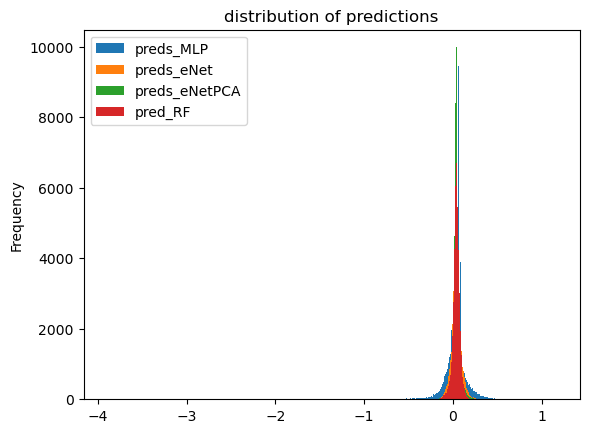

In [ ]:
# We can see predictions go negative at about the 25% percentile, market mainly goes up
predictions.plot(kind='hist', bins=1000, title="distribution of predictions")

**Join in predictions with the original dataset which has the cluster returns**

In [ ]:
# Bring in the data
data = load_features_data()

# join in predictions
predictions = predictions.merge(data, how="left", left_index=True, right_index=True)
predictions.sort_index(inplace=True)

# get the prediction columns
pred_cols = [f for f in predictions.columns if f.startswith('preds_')]

def getRetsForStrat(predictions, pred_cols):
    ret_list = []
    for pred_col in pred_cols:
        predictions[f'{pred_col}_signalQ'] = predictions.groupby(by='date')[pred_col].apply(lambda x: pd.qcut(x, 4, labels=False, duplicates='drop')).droplevel(0)
        predictions[f'{pred_col}_signalQ'] = predictions.groupby(by='cluster')[f'{pred_col}_signalQ'].shift(1)
        rets = predictions.groupby(by=['date', f'{pred_col}_signalQ'])['1d_ret'].mean().unstack()
        rets.rename(columns={col: f'{pred_col}_Q_{col}' for col in rets.columns}, inplace=True)
        ret_list.append(rets)
    return ret_list

ret_breakouts = []
# get all the returns
all_rets = getRetsForStrat(predictions, pred_cols)
for one_ret in all_rets:
    print(get_returns_breakout(one_ret))
    ret_breakouts.append(get_returns_breakout(one_ret))
    print('#################################')

# stack the returns
stacked_strat_rets = pd.concat([r.stack().to_frame('ret') for r in all_rets]) # this can hopefully be the data used for streamlit
stacked_strat_rets_cumprod = (1+stacked_strat_rets.unstack()).cumprod()

# save to pickle
stacked_strat_rets_cumprod.columns = stacked_strat_rets_cumprod.columns.droplevel(0)
stacked_strat_rets_cumprod.to_pickle("cum_cluster_returns.pkl")
pd.concat(ret_breakouts).to_pickle("metrics_df.pkl")

                Annual_Return Annual_Volatility        DD       MDD    Sharpe  \
preds_MLP_Q_0.0       0.09156          0.212027  0.144234 -0.568615  0.518376   
preds_MLP_Q_1.0      0.099061          0.209106  0.147033 -0.526411  0.568821   
preds_MLP_Q_2.0      0.069759           0.20818  0.148532 -0.649269  0.449408   
preds_MLP_Q_3.0      0.090617          0.212833  0.150864 -0.489226  0.558628   

                  Sortino    Calmar ppct_postive_rets  
preds_MLP_Q_0.0   0.76202  0.161023           0.54573  
preds_MLP_Q_1.0   0.80896  0.188183          0.527525  
preds_MLP_Q_2.0  0.629883  0.107443          0.506719  
preds_MLP_Q_3.0  0.788093  0.185225               0.5  
#################################
                 Annual_Return Annual_Volatility        DD       MDD  \
preds_eNet_Q_0.0       0.04934          0.210974  0.149305 -0.688197   
preds_eNet_Q_1.0      0.084987          0.211747  0.152664 -0.590507   
preds_eNet_Q_2.0       0.07505           0.21156  0.146758 -0.63